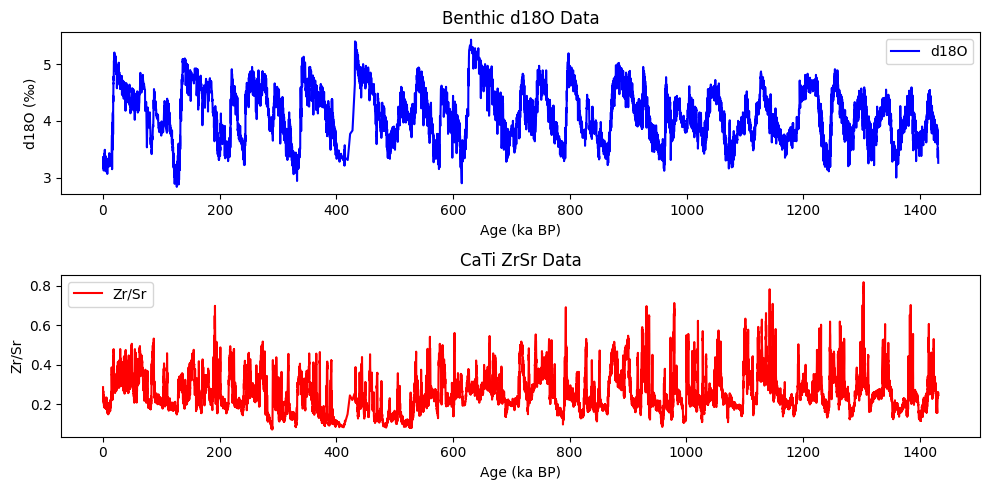

d18O df has nan: False
ZrSr df has nan: False


In [20]:
import pandas as pd

# Read the benthic d18O data, skipping the first 29 rows
df_d18O = pd.read_csv(
    r'D:\VScode\bipolar_seesaw_CCM\David_data\MD01-2444_339-U1385_combined_benthic_O18.tab',
    sep='\t',
    skiprows=29
)

# Read the CaTi ZrSr data, skipping the first 28 rows
# df_ZrSr = pd.read_csv(
#     r'D:\VScode\bipolar_seesaw_CCM\David_data\MD01-2444_CaTi_ZrSr.tab',
#     sep='\t',
#     skiprows=28
# )
df_ZrSr = pd.read_csv(
    r'D:\VScode\bipolar_seesaw_CCM\David_data\339-U1385_CaTi_ZrSr_ABDE_Splice.tab',
    sep='\t',
    skiprows=31
)
# for d18O_df, only keep the columns 'Age [ka BP] (Hybrid Age)' and 'δ18O [‰] (mixed species corrected to Uv...)' please rename them to 'age' and 'd18O'
df_d18O = df_d18O[['Age [ka BP] (Hybrid Age)', 'δ18O [‰] (mixed species corrected to Uv...)']]
df_d18O.columns = ['age', 'd18O']

# for df_ZrSr, only keep the columns 'Age [ka BP] (Hybrid Age)' and 'Zr/Sr (X-ray fluorescence Avaatech c...)' please rename them to 'age' and 'ZrSr'
df_ZrSr = df_ZrSr[['Age [ka BP] (Hybrid Age)', 'Zr/Sr (X-ray fluorescence Avaatech c...)']]
df_ZrSr.columns = ['age', 'ZrSr']

# plot the two df
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(df_d18O['age'], df_d18O['d18O'], label='d18O', color='blue')
plt.xlabel('Age (ka BP)')
plt.ylabel('d18O (‰)')
plt.title('Benthic d18O Data')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(df_ZrSr['age'], df_ZrSr['ZrSr'], label='Zr/Sr', color='red')
plt.xlabel('Age (ka BP)')
plt.ylabel('Zr/Sr')
plt.title('CaTi ZrSr Data')
plt.legend()
plt.tight_layout()
plt.show()

# drop nan  
df_d18O = df_d18O.dropna()
df_ZrSr = df_ZrSr.dropna()

# print whther there is nan in the two df
print('d18O df has nan:', df_d18O.isnull().values.any())
print('ZrSr df has nan:', df_ZrSr.isnull().values.any())

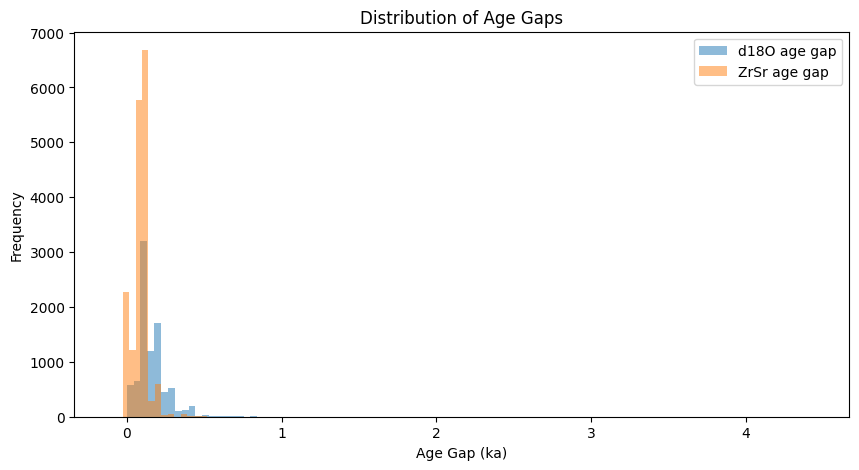

In [2]:
import matplotlib.pyplot as plt

# Calculate the difference between consecutive 'age' values for both dataframes
age_gap_d18O = df_d18O['age'].diff().dropna()
age_gap_ZrSr = df_ZrSr['age'].diff().dropna()

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(age_gap_d18O, bins=100, alpha=0.5, label='d18O age gap')
plt.hist(age_gap_ZrSr, bins=100, alpha=0.5, label='ZrSr age gap')
plt.xlabel('Age Gap (ka)')
plt.ylabel('Frequency')
plt.title('Distribution of Age Gaps')
plt.legend()
plt.show()


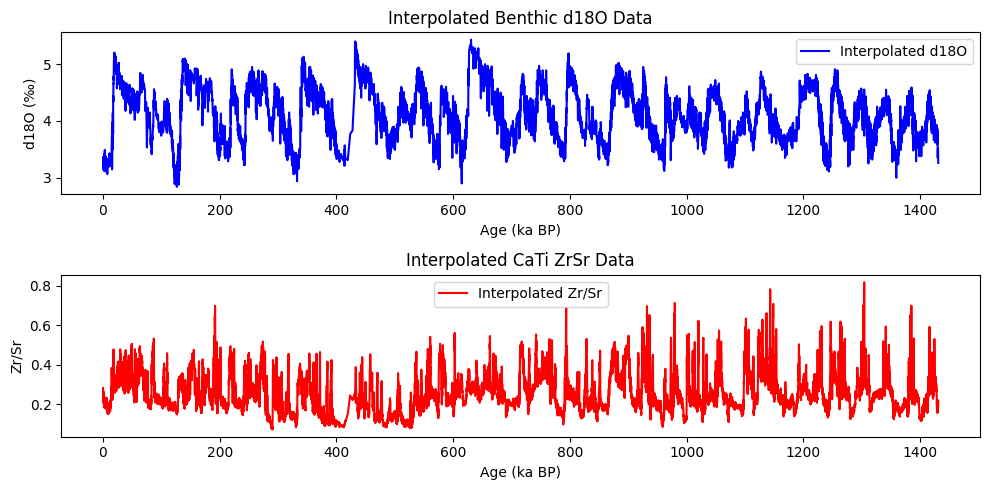

Are there any NaN values in the interpolated d18O data? False
Are there any NaN values in the interpolated ZrSr data? False


In [21]:
import numpy as np
# Determine the common age range, rounded to 0.01 kyr
start_age = max(round(df_d18O['age'].min(), 2), round(df_ZrSr['age'].min(), 2))
end_age = min(round(df_d18O['age'].max(), 2), round(df_ZrSr['age'].max(), 2))

# Create a common time axis with 0.01 kyr (10 yr) resolution
common_age = np.arange(start_age, end_age + 0.01, 0.01)

# Interpolate d18O and ZrSr to the common time axis
d18O_interp = np.interp(common_age, df_d18O['age'], df_d18O['d18O'])
ZrSr_interp = np.interp(common_age, df_ZrSr['age'], df_ZrSr['ZrSr'])

# Create new DataFrames for the interpolated data
df_d18O_interp = pd.DataFrame({'age': common_age, 'd18O': d18O_interp})
df_ZrSr_interp = pd.DataFrame({'age': common_age, 'ZrSr': ZrSr_interp})

# save the interpolated data to csv files
df_d18O_interp.to_csv(r'D:\VScode\bipolar_seesaw_CCM\David_data\MD01-2444_339-U1385_benthic_d18O_interp_10yr.csv', index=False)
df_ZrSr_interp.to_csv(r'D:\VScode\bipolar_seesaw_CCM\David_data\339-U1385_CaTi_ZrSr_interp_10yr.csv', index=False)

# plot the interpolated data
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(df_d18O_interp['age'], df_d18O_interp['d18O'], label='Interpolated d18O', color='blue')
plt.xlabel('Age (ka BP)')
plt.ylabel('d18O (‰)')
plt.title('Interpolated Benthic d18O Data')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(df_ZrSr_interp['age'], df_ZrSr_interp['ZrSr'], label='Interpolated Zr/Sr', color='red')
plt.xlabel('Age (ka BP)')
plt.ylabel('Zr/Sr')
plt.title('Interpolated CaTi ZrSr Data')
plt.legend()
plt.tight_layout()
plt.show()

# test are there any NaN values in the interpolated data
print("Are there any NaN values in the interpolated d18O data?", df_d18O_interp.isnull().values.any())
print("Are there any NaN values in the interpolated ZrSr data?", df_ZrSr_interp.isnull().values.any())

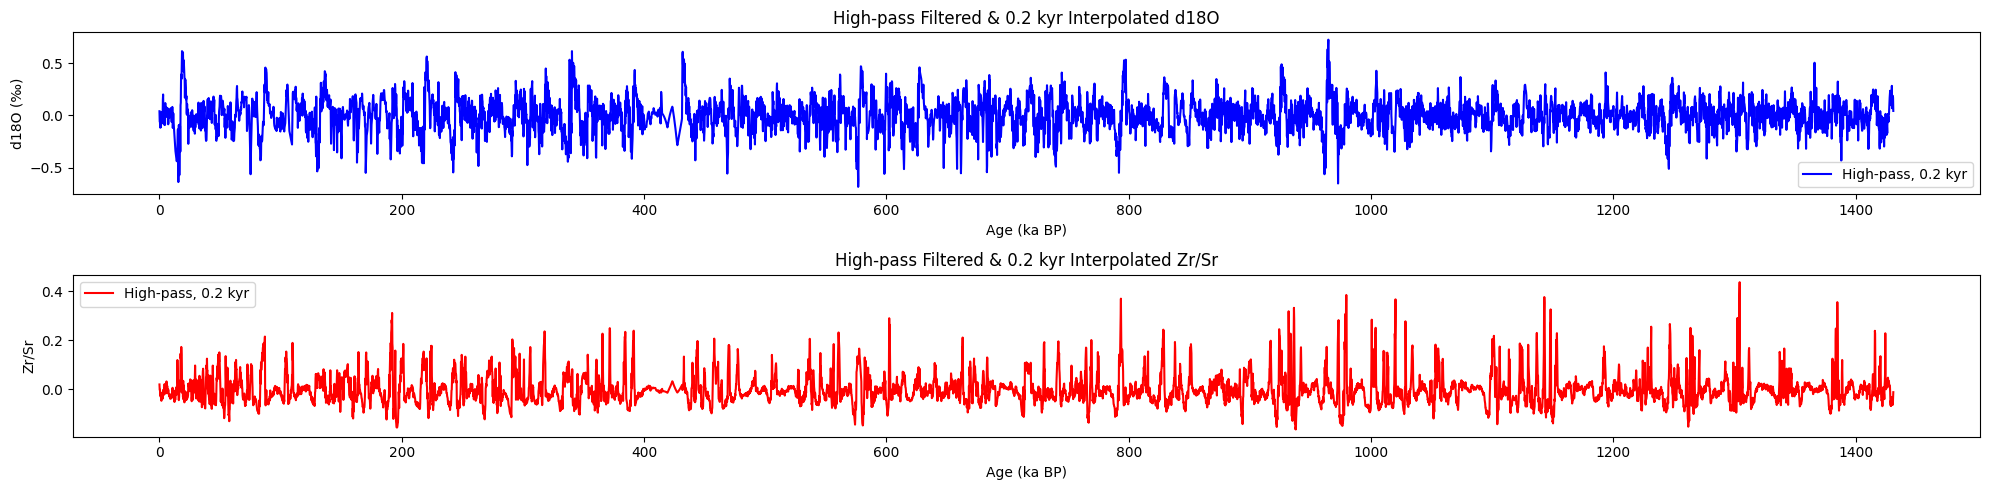

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 1) High-pass Butterworth filter design (2nd order, cutoff period = 20 kyr)
dt = 0.01            # kyr per sample (10 yr resolution)
fs = 1 / dt          # sampling frequency (samples per kyr)
nyq = fs / 2         # Nyquist frequency
fc = 1 / 20          # cutoff frequency (per kyr)
Wn = fc / nyq        # normalized cutoff

b, a = butter(N=2, Wn=Wn, btype='high')

# 2) Apply filter to interpolated series
d18O_filt = filtfilt(b, a, df_d18O_interp['d18O'].values)
ZrSr_filt = filtfilt(b, a, df_ZrSr_interp['ZrSr'].values)

# 3) Re-interpolate to 0.2 kyr steps
start_age = df_d18O_interp['age'].min()
end_age = df_d18O_interp['age'].max()
age_0_2 = np.arange(start_age, end_age + 0.2, 0.2)

d18O_0_2 = np.interp(age_0_2, df_d18O_interp['age'], d18O_filt)
ZrSr_0_2 = np.interp(age_0_2, df_ZrSr_interp['age'], ZrSr_filt)

# 4) Create DataFrames
df_d18O_0_2 = pd.DataFrame({'age': age_0_2, 'd18O_hp': d18O_0_2})
df_ZrSr_0_2 = pd.DataFrame({'age': age_0_2, 'ZrSr_hp': ZrSr_0_2})

# save the filtered and downsampled data to csv files
df_d18O_0_2.to_csv(r'D:\VScode\bipolar_seesaw_CCM\David_data\MD01-2444_339-U1385_benthic_d18O_hp_0.2kyr.csv', index=False)
df_ZrSr_0_2.to_csv(r'D:\VScode\bipolar_seesaw_CCM\David_data\339-U1385_CaTi_ZrSr_hp_0.2kyr.csv', index=False)

# 5) Plot filtered & downsampled series
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.plot(df_d18O_0_2['age'], df_d18O_0_2['d18O_hp'], color='blue', label='High-pass, 0.2 kyr')
plt.xlabel('Age (ka BP)')
plt.ylabel('d18O (‰)')
plt.title('High-pass Filtered & 0.2 kyr Interpolated d18O')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_ZrSr_0_2['age'], df_ZrSr_0_2['ZrSr_hp'], color='red', label='High-pass, 0.2 kyr')
plt.xlabel('Age (ka BP)')
plt.ylabel('Zr/Sr')
plt.title('High-pass Filtered & 0.2 kyr Interpolated Zr/Sr')
plt.legend()

plt.tight_layout()
plt.show()



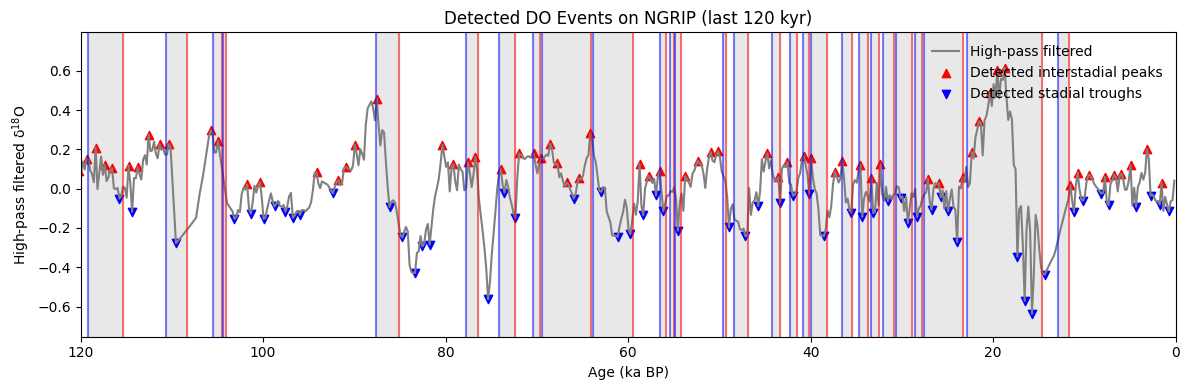

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def detect_do_events(df, value_col='d18O_hp', height_mult=1.0, deepth_mult=1.0, distance_kyr=1.0):
    """
    Identify interstadial (peaks) and stadial (valleys) in a high-pass filtered DO series.
    
    Parameters
    ----------
    df : DataFrame
        Must contain 'age' (ka BP) and filtered series column (e.g., 'd18O_hp').
    value_col : str
        Name of the column with the high-passed values.
    height_mult : float
        Threshold = height_mult * std(series).
    distance_kyr : float
        Minimum separation between events, in kyr.
    
    Returns
    -------
    peaks_age : array
        Ages of detected interstadial peaks.
    troughs_age : array
        Ages of detected stadial troughs.
    """
    ages = df['age'].values
    series = df[value_col].values
    # sampling interval (ka)
    dt = np.median(np.diff(ages))
    # distance in samples
    distance = int(distance_kyr / dt)
    # threshold on absolute amplitude
    thresh_peaks = height_mult * np.std(series)
    thresh_valley = deepth_mult * np.std(series)
    
    # detect peaks (interstadials)
    peaks_idx, _ = find_peaks(series, height=thresh_peaks, distance=distance)
    # detect troughs (stadials) by inverting
    troughs_idx, _ = find_peaks(-series, height=thresh_valley, distance=distance)
    
    peaks_age = ages[peaks_idx]
    troughs_age = ages[troughs_idx]
    return peaks_age, troughs_age


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# df_d18O_0_2 ['d18O_hp'] = df_d18O_0_2['d18O_hp'].values*-1

# Detect events
peaks_age, troughs_age = detect_do_events(df_d18O_0_2, 'd18O_hp', height_mult=0.1, deepth_mult=0.1, distance_kyr=1.0)

gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}
start_kyr_ori = np.array(gs_data["start"]) / 1000.0
end_kyr_ori   = np.array(gs_data["end"])   / 1000.0

start_kyr = start_kyr_ori
end_kyr   = end_kyr_ori
# if end-start <0.3, remove the pair
start_kyr = start_kyr_ori[end_kyr_ori - start_kyr_ori > 0.3]
end_kyr   = end_kyr_ori[end_kyr_ori - start_kyr_ori > 0.3]


# 3) Plotting
fig, ax = plt.subplots(figsize=(12, 4))
# Background strips
for s, e in zip(start_kyr, end_kyr):
    ax.axvspan(s, e, color='lightgray', alpha=0.5)

# Filtered series
ax.plot(df_d18O_0_2['age'], df_d18O_0_2['d18O_hp'], color='gray', label='High-pass filtered')
# plot start_kyr and end_kyr as vertical red and blue lines respectively
for s in start_kyr:
    ax.axvline(s, color='red', linestyle='-', alpha=0.5)
for e in end_kyr:
    ax.axvline(e, color='blue', linestyle='-', alpha=0.5)

# Detected events
ax.scatter(peaks_age, np.interp(peaks_age, df_d18O_0_2['age'], df_d18O_0_2['d18O_hp']), marker='^', color='red', label='Detected interstadial peaks')
ax.scatter(troughs_age, np.interp(troughs_age, df_d18O_0_2['age'], df_d18O_0_2['d18O_hp']), marker='v', color='blue', label='Detected stadial troughs')

# Limit to past 120 kyr
ax.set_xlim(120, 0)

ax.set_xlabel('Age (ka BP)')
ax.set_ylabel('High-pass filtered δ$^{18}$O')
ax.set_title('Detected DO Events on NGRIP (last 120 kyr)')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()



In [41]:
import numpy as np
import pandas as pd

# Known DO events in kyr (already in kyr!)
gs_data = {
    "start": np.array([11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
                       38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
                       58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
                       104040,104520,106750,108280,115370]) / 1000.0,
    "end":   np.array([12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
                       39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
                       58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
                       104380,105440,106900,110640,119140]) / 1000.0
}

start_kyr_ori = gs_data["start"]
end_kyr_ori   = gs_data["end"]

# remove any pairs shorter than 0.3 kyr
mask = (end_kyr_ori - start_kyr_ori) > 0.3
start_kyr = start_kyr_ori[mask]
end_kyr   = end_kyr_ori[mask]

tolerance = 0.1  # kyr
multipliers = np.arange(1, 3.1, 0.1)

best_total_matches   = -1
best_hmultiplier     = None
best_lmultiplier     = None
results = []

for hm in multipliers:
    for lm in multipliers:
        peaks_age, troughs_age = detect_do_events(
            df_d18O_0_2, 'd18O_hp',
            height_mult=hm,
            deepth_mult=lm,
            distance_kyr=1.0
        )
        
        # count how many known starts/endings are “hit”
        peak_matches = sum(
            np.any((peaks_age >= s - tolerance) & (peaks_age <= s + tolerance))
            for s in start_kyr
        )
        trough_matches = sum(
            np.any((troughs_age >= e - tolerance) & (troughs_age <= e + tolerance))
            for e in end_kyr
        )
        
        total_matches = peak_matches + trough_matches
        results.append((hm, lm, peak_matches, trough_matches, total_matches))
        
        if total_matches > best_total_matches:
            best_total_matches   = total_matches
            best_hmultiplier     = hm
            best_lmultiplier     = lm

# turn into a DataFrame
df_results = pd.DataFrame(
    results,
    columns=['hmultiplier', 'lmultiplier', 'peak_matches', 'trough_matches', 'total_matches']
)
df_results['match_rate'] = df_results['total_matches'] / (len(start_kyr) + len(end_kyr))

# pull out the exact row that gave the best result
best_info = df_results[
    (df_results['hmultiplier'] == best_hmultiplier) &
    (df_results['lmultiplier'] == best_lmultiplier)
].iloc[0]

print(f"Best height multiplier: {best_info.hmultiplier:.2f}")
print(f"Best depth  multiplier: {best_info.lmultiplier:.2f}")
print(f"Peak matches:   {int(best_info.peak_matches)} / {len(start_kyr)}")
print(f"Trough matches: {int(best_info.trough_matches)} / {len(end_kyr)}")
print(f"Total matches:  {int(best_info.total_matches)} / {len(start_kyr) + len(end_kyr)}")

# Optional: see the full table
df_results


Best height multiplier: 1.00
Best depth  multiplier: 1.00
Peak matches:   2 / 28
Trough matches: 0 / 28
Total matches:  2 / 56


,hmultiplier,lmultiplier,peak_matches,trough_matches,total_matches,match_rate
0,1.0,1.0,2,0,2,0.035714
1,1.0,1.1,2,0,2,0.035714
2,1.0,1.2,2,0,2,0.035714
3,1.0,1.3,2,0,2,0.035714
4,1.0,1.4,2,0,2,0.035714
...,...,...,...,...,...,...
436,3.0,2.6,0,0,0,0.000000
437,3.0,2.7,0,0,0,0.000000
438,3.0,2.8,0,0,0,0.000000
439,3.0,2.9,0,0,0,0.000000


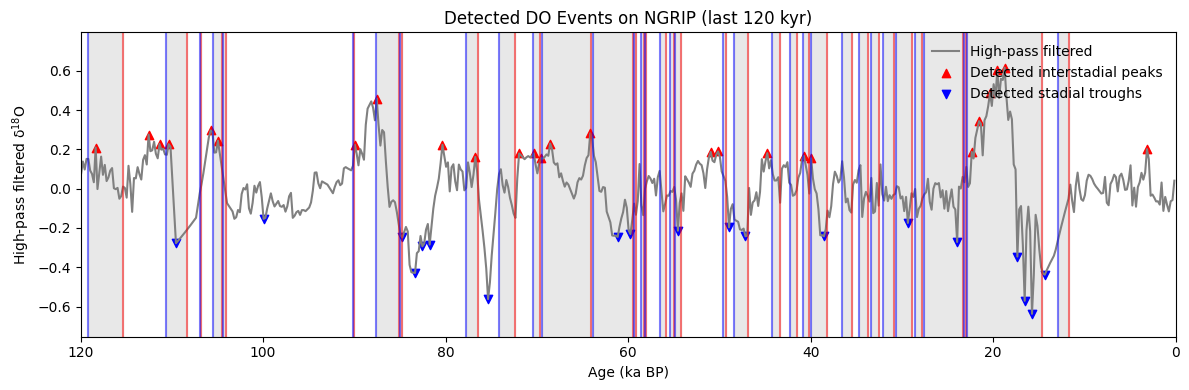

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# Detect events
peaks_age, troughs_age = detect_do_events(df_d18O_0_2, 'd18O_hp', height_mult=1.0, distance_kyr=1.0)

gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}
start_kyr = np.array(gs_data["start"]) / 1000.0
end_kyr   = np.array(gs_data["end"])   / 1000.0

# 3) Plotting
fig, ax = plt.subplots(figsize=(12, 4))
# Background strips
for s, e in zip(start_kyr, end_kyr):
    ax.axvspan(s, e, color='lightgray', alpha=0.5)

# Filtered series
ax.plot(df_d18O_0_2['age'], df_d18O_0_2['d18O_hp'], color='gray', label='High-pass filtered')
# plot start_kyr and end_kyr as vertical red and blue lines respectively
for s in start_kyr:
    ax.axvline(s, color='red', linestyle='-', alpha=0.5)
for e in end_kyr:
    ax.axvline(e, color='blue', linestyle='-', alpha=0.5)

# Detected events
ax.scatter(peaks_age, np.interp(peaks_age, df_d18O_0_2['age'], df_d18O_0_2['d18O_hp']), marker='^', color='red', label='Detected interstadial peaks')
ax.scatter(troughs_age, np.interp(troughs_age, df_d18O_0_2['age'], df_d18O_0_2['d18O_hp']), marker='v', color='blue', label='Detected stadial troughs')

# Limit to past 120 kyr
ax.set_xlim(120, 0)

ax.set_xlabel('Age (ka BP)')
ax.set_ylabel('High-pass filtered δ$^{18}$O')
ax.set_title('Detected DO Events on NGRIP (last 120 kyr)')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()
